# Projeto Análise de Preço em E-commerce de Cerveja

#Objetivo do projeto
Este projeto tem o objetivo de analisar padrões de preços em diferentes tipos de cervejas vendidas em comércios online especializados.
Estas análises tem o objetivo de responder perguntas do tipo:
- Qual a melhor loja para se comprar uma cerveja tipo Weiss (ou Porter, IPA, APA, etc.)?
- Qual a loja que possúi a menor média de preços para cervejas diversas?
- Qual tipo de cerveja apresenta uma média de preço acima da média para essas lojas?
- É possível construir um modelo de previsão de preços de cervejas baseado em seu tipo e lugar de venda?




In [ ]:
import os
import requests
import bs4
from bs4 import BeautifulSoup
import sys
import pandas as pd
import re
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#Extração de dados

##Fonte dos dados: 
- [Emporio da cerveja](https://www.emporiodacerveja.com.br/cervejas)
- [Cerveja Box](https://www.cervejabox.com.br/estilos)
- [Clube do Malte](https://www.clubedomalte.com.br/estilos)

##Parâmetros extraídos:
- Nome do produto
- Tipo de cerveja
- Preço do produto
- Preço por litro (preço/volume de bebida)
- Local de venda

In [ ]:
#Este dicionário mapeia as diferentes grafias encontradas para o tipo correto de cerveja
type_map = {
    'ipa':'IPA',
    'india pale ale':'IPA',
    'indian pale ale':'IPA',
    'american pale ale':'APA',
    'apa':'APA',
    'pale ale':'IPA',
    'belgian pale ale':'Belgian Pale Ale',
    'weisse':'Weiss',
    'weizen':'Weiss',
    'weiss':'Weiss',
    'weissbier':'Weiss',
    'new england ipa':'NEIPA',
    'juicy ipa':'NEIPA',
    'hazy':'NEIPA',
    'ne ipa':'NEIPA',
    'pilsner':'Bohemian Pilsner',
    'bohemian pilsner':'Bohemian Pilsner',
    'pils':'Bohemian Pilsner',
    'pilsen':'Pilsen',
    'wit':'Witbier',
    'golden ale':'Golden Ale',
    'gold ale':'Golden Ale',
    'blonde ale':'Blonde Ale',
    'blonde':'Blonde Ale',
    'blond':'Blonde Ale',
    'blond ale':'Blonde Ale',
    'amber ale':'Amber Ale',
    'red ale':'Red Ale',
    'amber lager':'Amber Ale',
    'red lager':'Red Lager',
    'sour':'Sour',
    'munich helles':'Munich Helles',
    'helles':'Munich Helles',
    'hell':'Munich Helles',
    'porter':'Porter',
    'stout':'Stout',
    'dunkel':'Dunkel',
    'dubbel':'Dubbel',
    'trippel':'Trippel',
    'tripel':'Trippel',
    'quadruppel':'Quadruppel',
    'quadrupel':'Quadruppel',
    'vienna lager':'Viena Lager',
    'viena lager':'Viena Lager',
    'lager':'Lager',
    'bitter':'Bitter',
}

estilos = ''
for i in type_map:
  estilos += i +'|'
estilos = estilos[:-1]

headers = ({'User-Agent':
            'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'})


In [ ]:
N_PAGS = 50
df_emporio = pd.DataFrame(columns=['Produto', 'Tipo', 'Preço', 'Preço (Litro)', 'Loja'])
for i in range(N_PAGS):
  url = 'https://www.emporiodacerveja.com.br/cervejas?page={}'.format(i)

  pag_prod = requests.get(url, headers=headers)

  pag_prod.encoding = 'utf-8'

  soup = BeautifulSoup(pag_prod.text, 'html.parser')

  lista_nome_produto = soup.find_all('span', class_='vtex-product-summary-2-x-productBrand vtex-product-summary-2-x-brandName t-body')
  lista_tipo_produto = soup.find_all('span', class_='emporiodacerveja-emporio-theme-2-x-specificationValue')
  lista_preco = preco_dec = soup.find_all('span', class_='vtex-store-components-3-x-sellingPrice vtex-store-components-3-x-sellingPriceValue vtex-product-summary-2-x-sellingPrice dib ph2 t-body t-heading-5-ns vtex-product-summary-2-x-price_sellingPrice')

  produto = []
  tipo = []
  preco = []
  preco_litro = []
  loja = []

  for i in range(len(lista_nome_produto)):
    if re.search('pack|kit|unidades|caixa', lista_nome_produto[i].text.lower()) or not re.search(r'[0-9]+ml\b', lista_nome_produto[i].text.lower()):
      continue
    
    produto.append(lista_nome_produto[i].text.strip())
    
    tip = lista_tipo_produto[i].text.strip()
    search1 = re.search(estilos, tip.lower())
    if search1:
      tipo.append(type_map[search1.group()])
    else:
      search2 = re.search(estilos, lista_nome_produto[i].text.lower())
      if search2:
        tipo.append(type_map[search2.group()])
      else:
        tipo.append(None)
    
    val = float(lista_preco[i].find('span', 'vtex-product-summary-2-x-currencyInteger').text + '.' + lista_preco[i].find('span', 'vtex-product-summary-2-x-currencyFraction').text)
    preco.append(val)
    preco_litro.append((val / int(re.search(r'[0-9]+ml\b', lista_nome_produto[i].text.lower()).group()[:-2])) * 1000)
    loja.append('Emporio da Cerveja')

  df_tmp = pd.DataFrame({'Produto':produto, 'Tipo':tipo, 'Preço':preco, 'Preço (Litro)':preco_litro, 'Loja':loja})
  df_emporio = df_emporio.append(df_tmp,ignore_index=True)

In [ ]:
df_emporio

,Produto,Tipo,Preço,Preço (Litro),Loja
0,Cerveja Colorado Barbaquá 473ML,None,9.90,20.930233,Emporio da Cerveja
1,Cerveja Goose Island Hazy IPA 355ml,NEIPA,11.99,33.774648,Emporio da Cerveja
2,Cerveja Patagonia Bohemian Pilsener 473ml,Bohemian Pilsner,7.99,16.892178,Emporio da Cerveja
3,Cerveja Patagonia 24.7 355ml,IPA,9.90,27.887324,Emporio da Cerveja
4,Cerveja Colorado Morena Tropicana 600ml,None,15.99,26.650000,Emporio da Cerveja
...,...,...,...,...,...
396,Cerveja Blondine Sunny Wheat 500ml,Blonde Ale,22.90,45.800000,Emporio da Cerveja
397,Cerveja Happy Brew Wit 600ml,Witbier,16.90,28.166667,Emporio da Cerveja
398,Cerveja Blondine Brett Ale 375ml,Blonde Ale,38.43,102.480000,Emporio da Cerveja
399,Cerveja Blondine Horny Pig 500ml,Blonde Ale,20.23,40.460000,Emporio da Cerveja


In [ ]:
N_PAGS = 50
df_cervejabox = pd.DataFrame(columns=['Produto', 'Tipo', 'Preço', 'Preço (Litro)', 'Loja'])
for i in range(N_PAGS):
  url = 'https://www.cervejabox.com.br/buscapagina?fq=C%3a%2f1%2f&PS=24&sl=15285295-d154-4ad0-a853-7fec8bb23b38&cc=24&sm=0&PageNumber={}'.format(i)

  pag_prod = requests.get(url, headers=headers)

  pag_prod.encoding = 'utf-8'

  soup = BeautifulSoup(pag_prod.text, 'html.parser')
  lista_nome_produto = soup.find_all('div', class_="product-name")
  lista_tipo_produto = soup.find_all('div', class_='wrapperConteudo')
  lista_preco = preco_dec = soup.find_all('span', class_='valor-por')

  produto = []
  tipo = []
  preco = []
  preco_litro = []

  for i in range(len(lista_nome_produto)):
    if re.search('pack|kit|unidades|caixa', lista_nome_produto[i].text.lower()) or not re.search(r'[0-9]+ml\b', lista_nome_produto[i].text.lower()) or not re.search('cerveja', lista_nome_produto[i].text.lower()):
      continue
    if i >= len(lista_preco):
      continue
    prod = lista_nome_produto[i].text.strip()
    produto.append(prod)
    
    search2 = re.search(estilos, lista_nome_produto[i].text.lower())
    pr = lista_tipo_produto[i].find('div', 'product-field product_field_28 product-field-type_7')
    if pr:
      tip = pr.li.text
      search1 = re.search(estilos, tip.lower())
      if search1:
        tipo.append(type_map[search1.group()])
      elif search2:
        tipo.append(type_map[search2.group()])
      else:
        tipo.append(None)
    else:
        if search2:
          tipo.append(type_map[search2.group()])
        else:
          tipo.append(None)
  
    val = float(lista_preco[i].text.strip().replace(',','.').replace('R$ ',''))
    preco.append(val)
    preco_litro.append((val / int(re.search(r'[0-9]+ml\b', lista_nome_produto[i].text.lower()).group()[:-2])) * 1000)
    loja.append('Cerveja Box')

  df_tmp = pd.DataFrame({'Produto':produto, 'Tipo':tipo, 'Preço':preco, 'Preço (Litro)':preco_litro})
  df_cervejabox = df_cervejabox.append(df_tmp,ignore_index=True)
  df_cervejabox['Loja'] = 'Cerveja Box'

In [ ]:
df_cervejabox

,Produto,Tipo,Preço,Preço (Litro),Loja
0,Cerveja Americana Pabst Blue Ribbon 350ml,Lager,4.99,14.257143,Cerveja Box
1,Cerveja Everbrew Everterps Blue Dream NEIPA 473ml,IPA,35.99,76.088795,Cerveja Box
2,Cerveja Infected Brewing Antidote Max Mosaic N...,NEIPA,35.99,76.088795,Cerveja Box
3,Cerveja Infected Brewing Poison Max Citra NEIP...,NEIPA,35.99,76.088795,Cerveja Box
4,Cerveja Artesanal Everbrew Feels Mosaic 473ml,NEIPA,36.99,78.202960,Cerveja Box
...,...,...,...,...,...
524,Cerveja artesanal Imigração Export 500ml,None,21.99,43.980000,Cerveja Box
525,Cerveja artesanal Everbrew Old is Cool Lata 473ml,IPA,35.99,76.088795,Cerveja Box
526,Cerveja alemã Erdinger sem alcool 300ml,None,26.99,89.966667,Cerveja Box
527,Cerveja artesanal Everbrew EverIPA Lata 473ml,IPA,35.99,76.088795,Cerveja Box


In [ ]:
N_PAGS = 50
df_clube = pd.DataFrame(columns=['Produto', 'Tipo', 'Preço', 'Preço (Litro)', 'Loja'])
for i in range(N_PAGS):
  url = 'https://www.clubedomalte.com.br/estilos?pagina={}'.format(i)

  pag_prod = requests.get(url, headers=headers)

  pag_prod.encoding = 'utf-8'

  soup = BeautifulSoup(pag_prod.text, 'html.parser')
  lista_nome_produto = soup.find_all('h2', class_="spot-title")
  lista_preco = preco_dec = soup.find_all('span', class_='fbits-valor')

  produto = []
  tipo = []
  preco = []
  preco_litro = []

  for i in range(len(lista_nome_produto)):
    if re.search('pack|kit|unidades|caixa', lista_nome_produto[i].text.lower()) or not re.search(r'[0-9]+ml\b', lista_nome_produto[i].text.lower()) or not re.search('cerveja', lista_nome_produto[i].text.lower()):
      continue
    if i >= len(lista_preco):
      continue
    prod = lista_nome_produto[i].text.strip()
    produto.append(prod)

    search2 = re.search(estilos, lista_nome_produto[i].text.lower())
    if search2:
      tipo.append(type_map[search2.group()])
    else:
      tipo.append(search2)

    val = float(lista_preco[i].text.strip().replace(',','.'))
    preco.append(val)
    preco_litro.append((val / int(re.search(r'[0-9]+ml\b', lista_nome_produto[i].text.lower()).group()[:-2])) * 1000)

  df_tmp = pd.DataFrame({'Produto':produto, 'Tipo':tipo, 'Preço':preco, 'Preço (Litro)':preco_litro})
  df_clube = df_clube.append(df_tmp,ignore_index=True)
  df_clube['Loja'] = 'Clube do Malte'

In [ ]:
df_clube

,Produto,Tipo,Preço,Preço (Litro),Loja
0,Cerveja Louvada India Pale Ale Garrafa 500ml,IPA,29.7,59.400000,Clube do Malte
1,Cerveja Louvada Benedita Coffee Stout Garrafa ...,Stout,24.9,70.140845,Clube do Malte
2,Cerveja Louvada Coffee Pilsen Garrafa 355ml,Bohemian Pilsner,16.9,47.605634,Clube do Malte
3,Cerveja Dado Bier Amber Lager Garrafa 600ml,Amber Ale,51.3,85.500000,Clube do Malte
4,Cerveja Dado Bier Tripel Hop Garrafa 600ml,Trippel,84.5,140.833333,Clube do Malte
...,...,...,...,...,...
338,Cerveja Paulaner Hefe Weiss Alkoholfrei Garraf...,Weiss,39.9,79.800000,Clube do Malte
339,Cerveja Shepherd Neame Spitfire Garrafa 500ml,None,39.9,79.800000,Clube do Malte
340,Cerveja La Trappe Blond Garrafa 330ml,Blonde Ale,34.9,105.757576,Clube do Malte
341,Cerveja Hofbrau Original Garrafa 500ml,None,37.9,75.800000,Clube do Malte


#Análise de dados

##Análise boxplot
Problema: Qual a diferença de preço e variedade entre tipos de cervejas nas 3 lojas?

Resultado:
- A loja "Empório da Cerveja" apresentou a melhor opção no quesito preço em relação a maioria dos tipos de cervejas
- A loja "Clube do Malte" apresenta muito mais rótulos com preço acima da média, comparado às outras lojas
- A loja "Clube do Malte" apresenta maior variedade de rótulos em relação às outras lojas

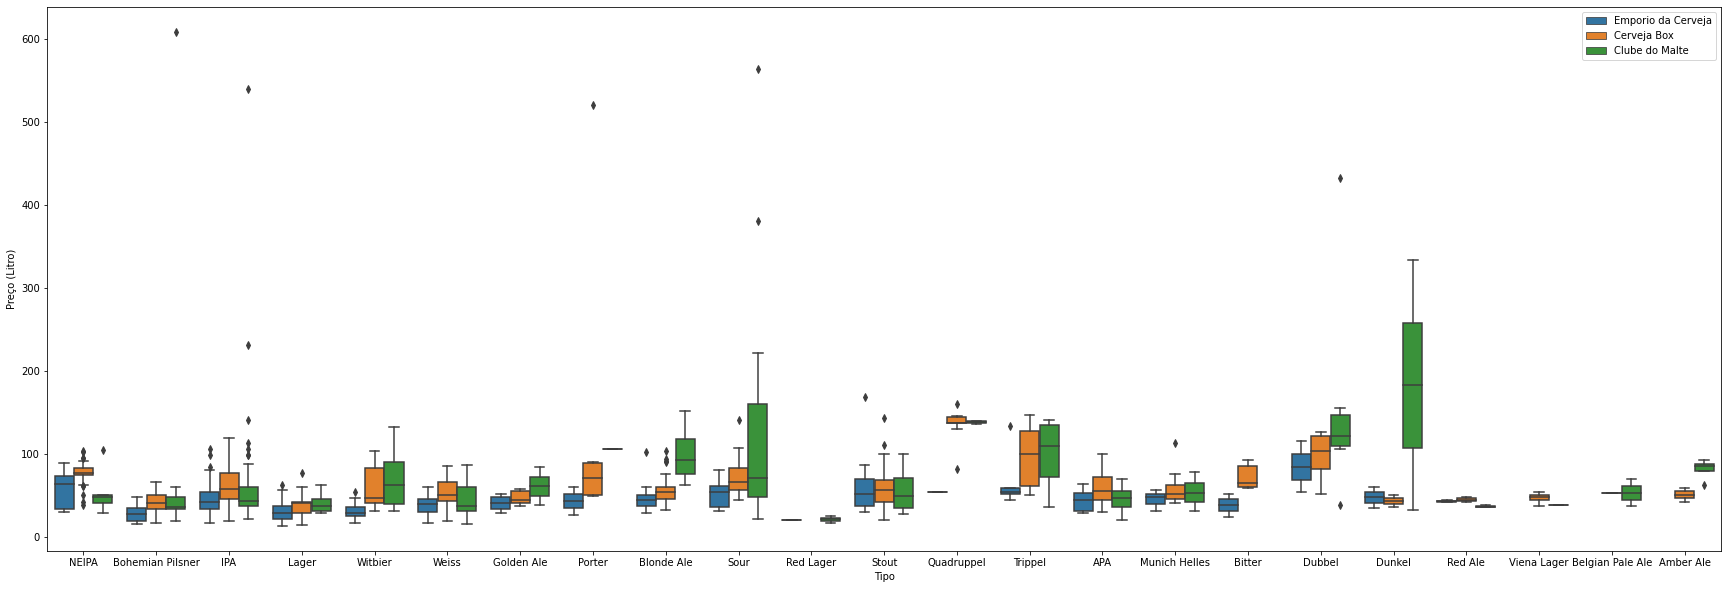

In [ ]:
horizontal_concat = pd.concat([df_emporio, df_cervejabox, df_clube], axis=0, ignore_index=True).dropna()
plt.figure(figsize=(30,10))
sns.boxplot(data=horizontal_concat, x='Tipo', y='Preço (Litro)', hue='Loja')
plt.legend()
plt.show()

 Informações de preço por tipo de cerveja na loja "CervejaBox"

In [ ]:
df_cervejabox.groupby(['Tipo'])['Preço (Litro)'].describe()

,count,mean,std,min,25%,50%,75%,max
Tipo,,,,,,,,
APA,22.0,58.207723,20.096471,29.971429,43.980000,54.463573,71.945116,99.969697
Amber Ale,2.0,50.553380,12.124591,41.980000,46.266690,50.553380,54.840070,59.126761
Belgian Pale Ale,1.0,52.832981,NaN,52.832981,52.832981,52.832981,52.832981,52.832981
Bitter,6.0,71.995711,15.576383,59.175476,59.980000,64.980000,85.654091,91.980000
Blonde Ale,24.0,57.025495,19.846177,32.542857,45.358366,53.736479,59.980000,103.000000
Bohemian Pilsner,27.0,40.743177,13.794743,16.183099,32.980000,39.980000,50.292326,65.685714
Dubbel,7.0,98.017676,30.531785,51.980000,81.063380,103.000000,121.181818,126.653333
Dunkel,2.0,42.980000,9.899495,35.980000,39.480000,42.980000,46.480000,49.980000
Golden Ale,5.0,46.772147,9.183813,37.114286,39.980000,43.980000,54.806452,57.980000


 Informações de preço por tipo de cerveja na loja "Empório da Cereveja"

In [ ]:
df_emporio.groupby(['Tipo'])['Preço (Litro)'].describe()

,count,mean,std,min,25%,50%,75%,max
Tipo,,,,,,,,
APA,12.0,43.343828,12.202072,28.971429,31.411507,44.435820,52.825650,63.213531
Bitter,2.0,37.716667,19.916841,23.633333,30.675000,37.716667,44.758333,51.800000
Blonde Ale,21.0,45.650249,15.964866,28.166667,36.333333,43.800000,49.800000,102.480000
Bohemian Pilsner,20.0,28.942381,10.908336,14.833333,18.537500,27.428510,34.282347,47.800000
Dubbel,2.0,84.077576,43.516637,53.306667,68.692121,84.077576,99.463030,114.848485
Dunkel,2.0,47.316667,17.654099,34.833333,41.075000,47.316667,53.558333,59.800000
Golden Ale,4.0,40.143545,10.647873,28.140845,33.160211,40.316667,47.300000,51.800000
IPA,103.0,45.261593,16.642203,16.514286,33.887324,41.500000,53.203052,105.800000
Lager,69.0,29.488361,10.645570,12.714286,21.608108,28.166667,36.321353,61.800000


 Informações de preço por tipo de cerveja na loja "Clube do Malte"

In [ ]:
df_clube.groupby(['Tipo'])['Preço (Litro)'].describe()

,count,mean,std,min,25%,50%,75%,max
Tipo,,,,,,,,
APA,16.0,44.694847,14.402133,19.800000,35.297040,47.050106,55.139085,69.800000
Amber Ale,4.0,81.341549,13.530636,61.690141,79.547535,85.500000,87.294014,92.676056
Belgian Pale Ale,2.0,53.069014,23.661187,36.338028,44.703521,53.069014,61.434507,69.800000
Blonde Ale,4.0,99.661929,38.823437,61.690141,75.422535,92.878788,117.118182,151.200000
Bohemian Pilsner,22.0,64.895672,121.734920,19.436620,33.521127,36.069014,47.605634,608.169014
Dubbel,6.0,161.975772,137.716075,37.800000,109.545455,120.909091,146.213188,431.830986
Dunkel,2.0,182.483333,213.098414,31.800000,107.141667,182.483333,257.825000,333.166667
Golden Ale,2.0,60.833333,32.574052,37.800000,49.316667,60.833333,72.350000,83.866667
IPA,62.0,61.135402,69.939655,20.930233,36.338028,42.571429,59.296300,539.800000


In [ ]:
df_clube[df_clube['Preço (Litro)'] > 500]

,Produto,Tipo,Preço,Preço (Litro),Loja
49,Cerveja Sierra Nevada Wild Little Thing Sour A...,Sour,200.0,563.380282,Clube do Malte
87,Cerveja Abadia Luiaard Abbey Ale Garrafa 355ml,None,179.9,506.760563,Clube do Malte
109,Cerveja Bamberg Micalateia Pilsen Garrafa 355ml,Bohemian Pilsner,215.9,608.169014,Clube do Malte
222,Cerveja Fuller's Imperial IPA Garrafa 500ml,IPA,269.9,539.800000,Clube do Malte
250,Cerveja Fuller's Vintage Ale 2016 Garrafa 500ml,None,299.9,599.800000,Clube do Malte
266,Cerveja Fuller's Vintage Ale 2015 Garrafa 500ml,None,299.9,599.800000,Clube do Malte


##Regressão linear

Problema: Será que é possível prever o preço por litro de uma cerveja baseado em seu tipo e local de venda?

Resultado: Ao observar as previsões nos dados de teste, é possível concluir que o modelo está longe da acurácia ideal. Mesmo assim, é possível perceber que as previsões com preços entre 20 e 100 reais se concentram próximas ao preço correto, indicando que, se houvessem mais dados disponíveis, uma regressão poderia ser implementada com maior precisão para essa faixa de preço. Já para cervejas com preços por litro acima de 100 reais, o modelo performou de forma inconclusiva por falta de dados.

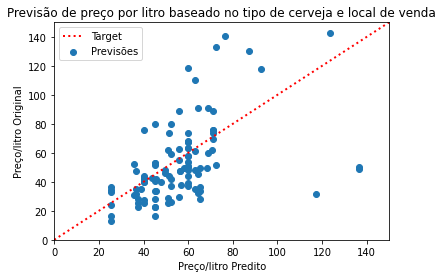

,Predito,Real
636,60.00,118.281690
562,71.00,76.088795
543,60.00,58.032258
41,45.00,40.360000
746,52.50,41.980000
...,...,...
79,56.00,29.771429
587,136.50,49.980000
974,56.50,47.605634
652,60.00,63.403805


In [ ]:
#Análise de regrssão linear para prever preço por litro
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from collections import Counter
from sklearn.model_selection import train_test_split

# X is a numpy array with your features
# y is the label array
enc = OneHotEncoder(sparse=False)

#Concatenating dataframes
horizontal_concat = pd.concat([df_emporio, df_cervejabox, df_clube], axis=0, ignore_index=True).dropna()
x = horizontal_concat.drop(['Produto', 'Preço', 'Preço (Litro)'], axis=1)
X = pd.get_dummies(data=x)
#print(X.columns)

Y = horizontal_concat['Preço (Litro)']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

#Train
model = LinearRegression()
model.fit(X_train,y_train)

#Predict and plot
predictions = model.predict(X_test)

plt.title("Previsão de preço por litro baseado no tipo de cerveja e local de venda")
plt.xlabel("Preço/litro Predito")
plt.ylabel("Preço/litro Original")

plt.plot([0, 150], [0, 150], color = 'red', linewidth = 2, linestyle=':', label='Target')
plt.scatter(predictions, y_test, label='Previsões')
plt.legend()
plt.xlim(0, 150)
plt.ylim(0, 150)
plt.show()

df_compare = pd.DataFrame({'Predito': predictions, 'Real': y_test})
df_compare

#Conclusão

Ao observar os resultados, é possível perceber que diferentes lojas possuem sim diferenças significativas em seus preços de cervejas, quando comparamos os mesmo tipos.
Porém, com a quantidade de dados obtidos, não foi possível desenvolver um modelo de regressão que pudesse prever o preço por litro das cervejas baseado em seus tipos e locais de venda.

Assim, como futuros deesenvolvimentos deste  projeto, sugere-se realizar uma coleta temporal de dados, onde os preços de cervejas são atualizados diariamente, e também o aumento no número de variáveis como por exemplo o país de origem da cerveja ou informações sobre o produtor, para então realizar-se novas análises com maior precisão.